In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import utils

## P-value distribution

Large divergences of the p-value distribution from expectations may indicate problems with a statistical model. 

#### Read in cancer gene census

All mutations in Cancer Gene Census genes will be removed to assess the p-value distribution.

In [2]:
cgc = utils.process_cgc('CHASM2/data/Census_allSat Jan  7 18-57-49 2017.tsv')

### Read/process p-value


In [3]:
# read chasm results
useful_cols = ['UID', 'gene', 'CHASM2', 'CHASM2_genome', 'driver score', 'CHASM2_genome_pval', 'CHASM2_pval', 'CHASM2_genome_qval', 'CHASM2_qval']
df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', usecols=useful_cols)

# read hotspot result
useful_cols = ['Hugo_Symbol', 'Amino_Acid_Position', 'log10_pvalue', 'Variant_Amino_Acid', 'qvalue']
hotspot_df = pd.read_table('CHASM2/data/sig_hotspots_pancan_no_skcm_q_101.txt', usecols=useful_cols)
hotspot_df['pvalue'] = 10**hotspot_df['log10_pvalue']

In [4]:
# read mutations from maf file
mut_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.maf')
mut_df['UID'] = range(len(mut_df))
# count the recurrence of a mutation
recurrence = mut_df.groupby(['Transcript_ID', 'HGVSp_Short']).size().reset_index(name='recurrence')
# add the recurrence of the mutation to the MAF file
mut_df = pd.merge(mut_df, recurrence, on=['Transcript_ID', 'HGVSp_Short'], how='left')
df = pd.merge(df, mut_df[['UID', 'Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'recurrence']], on='UID', how='left')

### P-value QQ plot (Supplementary Figure 1)

Calculate the mean log fold change (MLFC) and create the qq-plot of the p-values. Mutations in the CGC are excluded to represent mostly mutations that are likely passengers.

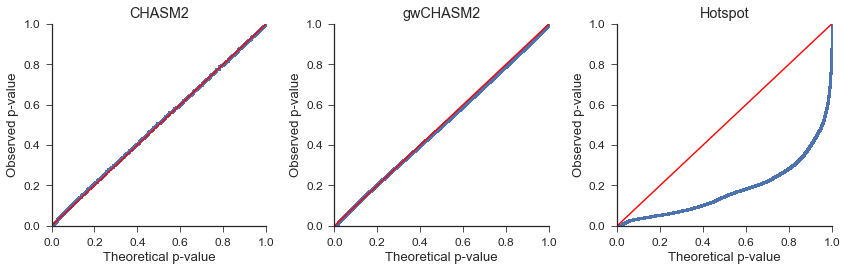

In [6]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.5):
    # create two panel figure
    fig, axes = plt.subplots(1, 3)
    
    # plot CHASM2
    not_cgc = ~df['gene'].isin(cgc)
    ax = axes[0]
    tmp_pval = df[not_cgc]['CHASM2_pval'].dropna()
    utils.qqplot(tmp_pval, log=False, ax=ax)
    ax.set_xlim((0, 1)); ax.set_ylim((0, 1))
    tmp_mlfc = utils.mean_log_fold_change(tmp_pval)
    ax.set_title('CHASM2') # (MLFC={0:.2g})'.format(tmp_mlfc))
    ax = axes[1]
    tmp_pval = df[not_cgc]['CHASM2_genome_pval'].dropna()
    utils.qqplot(tmp_pval, log=False, ax=ax)
    ax.set_xlim((0, 1)); ax.set_ylim((0, 1))
    tmp_mlfc = utils.mean_log_fold_change(tmp_pval)
    ax.set_title('gwCHASM2') # (MLFC={0:.2g})'.format(tmp_mlfc))
    
    # plot Chang et al hotspot method
    ax = axes[2]
    not_cgc = ~hotspot_df['Hugo_Symbol'].isin(cgc)
    tmp_pval = hotspot_df[not_cgc]['pvalue'].dropna()
    utils.qqplot(tmp_pval, log=False, ax=ax)
    ax.set_xlim((0, 1)); ax.set_ylim((0, 1))
    tmp_mlfc = utils.mean_log_fold_change(tmp_pval)
    ax.set_title('Hotspot') # (MLFC={0:.2g})'.format(tmp_mlfc))
    
    # adjust layout
    plt.gcf().set_size_inches((12,4))
    plt.tight_layout()
    plt.savefig('CHASM2/figures/figure_s1c.png')